In [1]:
import sys
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid");

sys.path.append("../lib")

device = torch.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

### Step 1: Loading the model

We prepared our custom Steam dataset with over 80,000 games and corresponding images for each of them. We can read this dataset from the `data` directory.

In [2]:
import msgspec
from steam_model import SteamGame
from pathlib import Path

data_root = Path("./data/steam")
steam_games = data_root / "games.json"

games = msgspec.json.decode(steam_games.read_text(), type=list[SteamGame])

excluded_genres = set([
    "Accounting",
    "Animation & Modeling",
    "Audio Production",
    "Design & Illustration",
    "Education",
    "Game Development",
    "Movie",
    "Photo Editing",
    "Software Training",
    "Utilities",
    "Video Production",
    "Web Publishing"
])

dataset = [
    {
        "id": game.id,
        "title": game.page_information.title,
        "image": image,
        "genres": game.page_information.genres
    }
    for game
    in games
    if game.page_information.images
        and game.popularity_rank < 5000
        and next((genre for genre in game.page_information.genres if genre in excluded_genres), None) is None
        and game.page_information.genres
    for image in game.page_information.images
]
base_df = pd.DataFrame.from_records(dataset)
one_hot_genres = base_df["genres"].str.join("|").str.get_dummies()

df = pd.concat([base_df, one_hot_genres], axis=1)
df.head()

,id,title,image,genres,Action,Adventure,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,553850,HELLDIVERS™ 2,images/553850/ss_0c79f56fc7be1bd0102f2ca1c92c8...,[Action],1,0,0,0,0,0,0,0,0,0,0,0
1,553850,HELLDIVERS™ 2,images/553850/ss_33e684e9cb2517af1599f0ca2b57d...,[Action],1,0,0,0,0,0,0,0,0,0,0,0
2,553850,HELLDIVERS™ 2,images/553850/ss_8949ed7dd24a02d5ea13b08fc5c04...,[Action],1,0,0,0,0,0,0,0,0,0,0,0
3,553850,HELLDIVERS™ 2,images/553850/ss_50afbbc4d811c38fe9f64c1fc8d7e...,[Action],1,0,0,0,0,0,0,0,0,0,0,0
4,553850,HELLDIVERS™ 2,images/553850/ss_cb276fe9f0b09683bdbc496f82b40...,[Action],1,0,0,0,0,0,0,0,0,0,0,0


Let's define a few convenience functions to easily get an image for a given game:

In [3]:
labels = df.columns[4:]
id2label = { id: label for id, label in enumerate(labels) }
label2id = { label: id for id, label in enumerate(labels) }

def get_labels_from_one_hot(one_hot: torch.Tensor) -> list[str]:
    return [id2label[id] for id in torch.nonzero(one_hot).squeeze().tolist()]

id2label

{0: 'Action',
 1: 'Adventure',
 2: 'Casual',
 3: 'Early Access',
 4: 'Free to Play',
 5: 'Indie',
 6: 'Massively Multiplayer',
 7: 'RPG',
 8: 'Racing',
 9: 'Simulation',
 10: 'Sports',
 11: 'Strategy'}

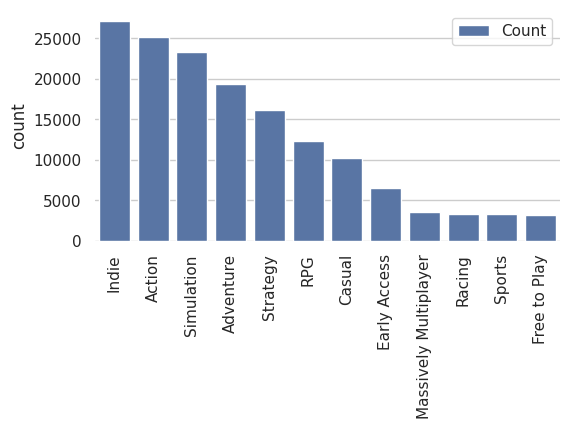

In [4]:
genre_counts = df["genres"].explode().value_counts().reset_index()

f, ax = plt.subplots(figsize=(6, 3))

sns.barplot(y="count", x="genres", data=genre_counts, label="Count")
sns.despine(left=True, bottom=True)
ax.set(xlabel="")
ax.tick_params(axis="x", rotation=90)

In [5]:
# Set up label weights because the dataset is quite imbalanced
def calculate_label_weights(dataset: pd.DataFrame, label2id: dict[str, int], genre_counts: pd.DataFrame) -> torch.Tensor:
    genre_counts["genre_order"] = genre_counts["genres"].map(label2id)
    sorted_genres = genre_counts.sort_values("genre_order")
    sorted_genres.drop("genre_order", axis=1, inplace=True)

    dataset_size = sorted_genres["count"].sum()
    genre_counts_tensor = torch.tensor(sorted_genres["count"].tolist())

    return (dataset_size - genre_counts_tensor) / genre_counts_tensor

label_weights = calculate_label_weights(df, label2id, genre_counts)
label_weights

tensor([ 5.1132,  6.9230, 13.9318, 22.6726, 47.4505,  4.6531, 41.7465, 11.5011,
        44.7379,  5.5853, 45.7686,  8.5266])

In [6]:
from transformers import Dinov2ForImageClassification, Dinov2Config
from transformers.modeling_outputs import ImageClassifierOutput
from typing import Optional, Union
from torch.nn import BCEWithLogitsLoss

class DinoV2ForImbalancedImageClassification(Dinov2ForImageClassification):
    def __init__(self, config: Dinov2Config, label_weights: torch.Tensor):
        super().__init__(config)
        self.label_weights = label_weights
        self.config.problem_type = "multi_label_classification"
        assert self.num_labels > 0, "This class should only be used for multi-label classification"
        assert self.num_labels == len(label_weights), "Label weights must be the same length as the number of labels"

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageClassifierOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.dinov2(
            pixel_values,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]  # batch_size, sequence_length, hidden_size

        cls_token = sequence_output[:, 0]
        patch_tokens = sequence_output[:, 1:]

        linear_input = torch.cat([cls_token, patch_tokens.mean(dim=1)], dim=1)
        logits = self.classifier(linear_input)

        # move labels to correct device to enable model parallelism
        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            loss_fct = BCEWithLogitsLoss(pos_weight=self.label_weights.to(logits.device))
            loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [7]:
import typing
from transformers import BitImageProcessor, BitsAndBytesConfig
from peft import LoraConfig, LoftQConfig, get_peft_model

model_id = "facebook/dinov2-large"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

image_processor = typing.cast(BitImageProcessor, BitImageProcessor.from_pretrained(model_id))
base_model = typing.cast(DinoV2ForImbalancedImageClassification, DinoV2ForImbalancedImageClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    label_weights=label_weights,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
))

loftq_config = LoftQConfig(loftq_bits=4)
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules="all-linear",
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
model = get_peft_model(base_model, config)
model.print_trainable_parameters()
model.to(device)


Some weights of DinoV2ForImbalancedImageClassification were not initialized from the model checkpoint at facebook/dinov2-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 7,102,476 || all params: 311,495,704 || trainable%: 2.280120049424502


PeftModel(
  (base_model): LoraModel(
    (model): DinoV2ForImbalancedImageClassification(
      (dinov2): Dinov2Model(
        (embeddings): Dinov2Embeddings(
          (patch_embeddings): Dinov2PatchEmbeddings(
            (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): Dinov2Encoder(
          (layer): ModuleList(
            (0-23): 24 x Dinov2Layer(
              (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (attention): Dinov2Attention(
                (attention): Dinov2SelfAttention(
                  (query): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_fea

In [8]:
import numpy as np
import PIL.Image
from torch.utils.data import Dataset
from torchvision.transforms import v2

label_smoothing = 0.1
smoothed_label_threshold = (1 * (1 - label_smoothing) + label_smoothing / len(labels)) - 0.1

class MultiLabelDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame, transform: v2.Compose):
        self.root = root
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        item = self.df.iloc[idx]

        # First, get the image
        image_path = self.root / item["image"]
        image = PIL.Image.open(image_path).convert("RGB")

        # Then, prepare the image for the model
        pixel_values = self.transform(image)

        # Get the labels as a PyTorch tensor
        labels = item[4:].values.astype(np.float32)
        labels = torch.from_numpy(labels)

        smoothed_labels = labels * (1 - label_smoothing) + label_smoothing / len(labels)

        return { "pixel_values": pixel_values, "labels": smoothed_labels }
    
    def get_raw_image(self, idx: int) -> PIL.Image.Image:
        item = self.df.iloc[idx]
        image_path = self.root / item["image"]
        return PIL.Image.open(image_path).convert("RGB")


torch.Size([3, 256, 256]) ['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Indie', 'Massively Multiplayer', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']


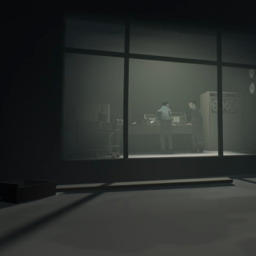

In [9]:
from sklearn.model_selection import train_test_split

size = image_processor.size["shortest_edge"]
mean = typing.cast(list[float], image_processor.image_mean)
std = typing.cast(list[float], image_processor.image_std)

transform = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(size,size), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

# Denormalize the pixel values to see that the image is also correctly loaded
def inverse_transform(pixel_values: torch.Tensor) -> PIL.Image.Image:
    unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return PIL.Image.fromarray(unnormalized_image)

# Split our data into training and validation sets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=100)

# Create and verify that the dataset works as we expect
train_dataset = MultiLabelDataset(root=data_root, df=train_df, transform=transform)
eval_dataset = MultiLabelDataset(root=data_root, df=eval_df, transform=transform)

first = train_dataset[1]
print(first["pixel_values"].shape, get_labels_from_one_hot(first["labels"]))
inverse_transform(first["pixel_values"])

In [10]:
from transformers import TrainingArguments, Trainer, EvalPrediction, IntervalStrategy, EarlyStoppingCallback
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

Batch = dict[str, torch.Tensor]

def data_collator(batch: list[dict[str, torch.Tensor]]) -> Batch:
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return { "pixel_values": pixel_values, "labels": labels }

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    # finally, compute metrics
    y_true = np.zeros(labels.shape)
    y_true[np.where(labels >= smoothed_label_threshold)] = 1

    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)

    return {'f1_micro': f1_micro, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'roc_auc': roc_auc, 'accuracy': accuracy}

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

training_args = TrainingArguments(
    output_dir="steam_genre_classifier",
    remove_unused_columns=False,
    evaluation_strategy=IntervalStrategy.STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_total_limit=10,
    eval_steps=50,
    save_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    label_names=["labels"],
    tf32=True,
    bf16=True,
    optim="adamw_bnb_8bit",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


In [11]:
trainer.train()

  0%|          | 0/4104 [00:00<?, ?it/s]

{'loss': 2.6352, 'grad_norm': 13.8666410446167, 'learning_rate': 1.2165450121654502e-06, 'epoch': 0.01}
{'loss': 2.4945, 'grad_norm': 11.093249320983887, 'learning_rate': 2.4330900243309005e-06, 'epoch': 0.01}
{'loss': 2.5587, 'grad_norm': 9.704916000366211, 'learning_rate': 3.64963503649635e-06, 'epoch': 0.02}
{'loss': 2.6094, 'grad_norm': 13.298721313476562, 'learning_rate': 4.866180048661801e-06, 'epoch': 0.03}
{'loss': 2.6796, 'grad_norm': 9.597121238708496, 'learning_rate': 6.082725060827251e-06, 'epoch': 0.04}


  0%|          | 0/1369 [00:00<?, ?it/s]

KeyboardInterrupt: 